In this notebook, I use image processing and transfer learning with the ResNet-50 model in PyTorch to predict facial emotions such as sad, happy, fear, surprise, and angry. I then deploy the model to build an application.
The dataset is available at:
https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions/data

In [1]:
import os, random, json
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

**discover the dataset**

In [2]:

data_path = "/kaggle/input/human-face-emotions/Data"

# List folders (emotion labels)
folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

print("Emotion folders in Data:")
for folder in folders:
    print("-", folder)


Emotion folders in Data:
- Fear
- Suprise
- Angry
- Sad
- Happy


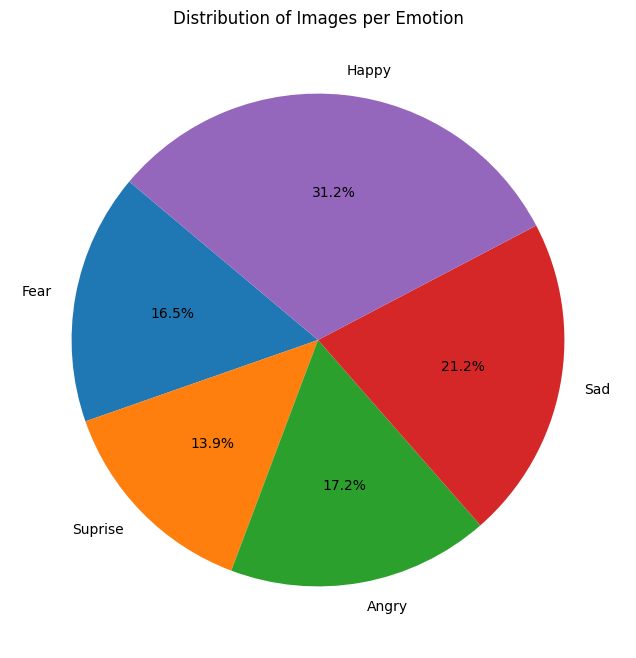

In [3]:


data_path = "/kaggle/input/human-face-emotions/Data"

folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

# Count images per folder
counts = [len(os.listdir(os.path.join(data_path, folder))) for folder in folders]

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(counts, labels=folders, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Images per Emotion")
plt.show()


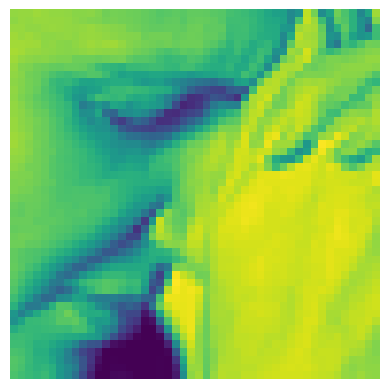

In [4]:


example_folder = folders[0]
example_img = os.listdir(os.path.join(data_path, example_folder))[0]

img_path = os.path.join(data_path, example_folder, example_img)
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.show()


In [5]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Data augmenatation** **with split data to train test evaluation**

In [17]:
def get_dataloaders(data_dir, input_size=224, batch_size=32, val_split=0.15, test_split=0.15):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    eval_tf = transforms.Compose([
        transforms.Resize(int(input_size*1.14)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    full = datasets.ImageFolder(data_dir, transform=train_tf)
    classes = full.classes
    n = len(full)
    
    
    val_n = int(n * val_split)
    test_n = int(n * test_split)
    train_n = n - val_n - test_n
    
    
    train_set, val_set, test_set = random_split(full, [train_n, val_n, test_n])
    
    
    val_set.dataset.transform = eval_tf
    test_set.dataset.transform = eval_tf
    
    
    loaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
    }
    return loaders, classes

**Fintuning**

In [18]:
def build_finetune_model(model_name, num_classes):
    model_name = model_name.lower()
    
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError("Model not implemented")
    
    # Fine-tuning: unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    
    return model.to(device)


In [19]:
data_path = "/kaggle/input/human-face-emotions/Data"
loaders, classes = get_dataloaders(data_path, input_size=224, batch_size=32)
num_classes = len(classes)


In [20]:
model = build_finetune_model("resnet50", num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


In [22]:
def train_model(model, loaders, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0
        running_corrects = 0
        
        for inputs, labels in tqdm(loaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss / len(loaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(loaders['train'].dataset)
        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in loaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
        
        val_acc = val_corrects.double() / len(loaders['val'].dataset)
        print(f"Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
    
    print(f"\nBest Val Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [24]:
trained_model = train_model(model, loaders, criterion, optimizer, scheduler, num_epochs=5)



Epoch 1/5


100%|██████████| 1293/1293 [09:57<00:00,  2.16it/s]


Train Loss: 0.7997 Acc: 0.6871
Val Acc: 0.7407

Epoch 2/5


100%|██████████| 1293/1293 [07:21<00:00,  2.93it/s]


Train Loss: 0.5154 Acc: 0.8078
Val Acc: 0.7990

Epoch 3/5


100%|██████████| 1293/1293 [07:17<00:00,  2.95it/s]


Train Loss: 0.3089 Acc: 0.8902
Val Acc: 0.8533

Epoch 4/5


100%|██████████| 1293/1293 [06:56<00:00,  3.11it/s]


Train Loss: 0.1868 Acc: 0.9353
Val Acc: 0.8688

Epoch 5/5


100%|██████████| 1293/1293 [06:57<00:00,  3.10it/s]


Train Loss: 0.1350 Acc: 0.9539
Val Acc: 0.8835

Best Val Accuracy: 0.8835


Accuracy: 0.8792870036101083
              precision    recall  f1-score   support

       Angry       0.88      0.82      0.85      1580
        Fear       0.78      0.82      0.80      1471
       Happy       0.96      0.95      0.95      2745
         Sad       0.81      0.88      0.84      1854
     Suprise       0.94      0.88      0.91      1214

    accuracy                           0.88      8864
   macro avg       0.87      0.87      0.87      8864
weighted avg       0.88      0.88      0.88      8864



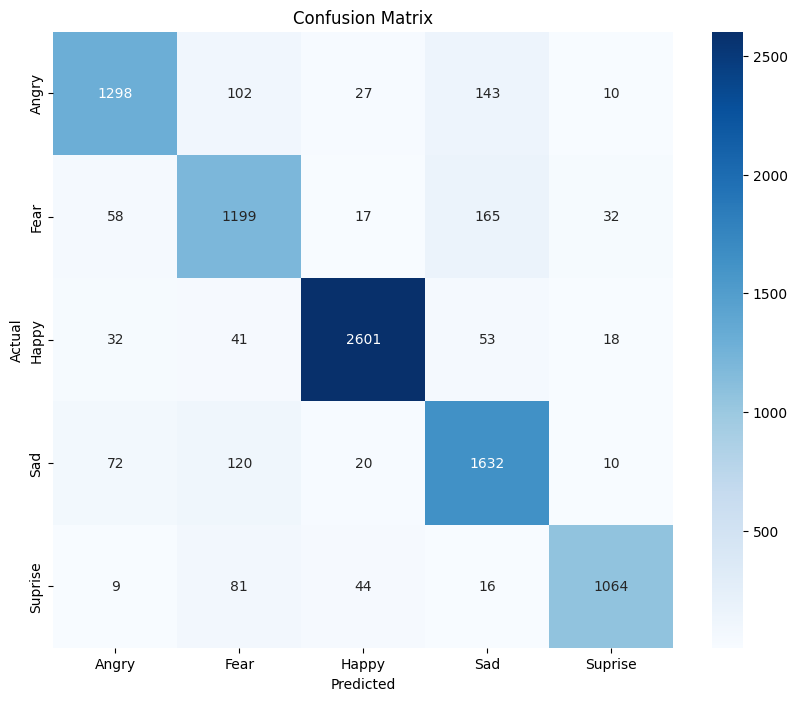

In [26]:
import seaborn as sns

trained_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [27]:
# Save the best trained model weights
torch.save(trained_model.state_dict(), "/kaggle/working/emotion_model.pth")
print("Model weights saved successfully!")


Model weights saved successfully!
